In [1]:
%load_ext autoreload
%autoreload 2 

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay, roc_curve, auc


from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe

# Path to data

In [4]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'

# Data Processing

In [144]:
processor_pipe = (ClassifierPipe(DATA_PATH)
             .read_raw_data()
             .calculate_max_min_signal()
             .drop_columns(["event", "trial"])
             .split_data(test_size=0.2,
                test_dev_size=0.5, 
                split_group = "mouse_id", 
                stratify_group = "sex", 
                target='action',
                save_subject_ids=False)
                # path_to_save =os.path.dirname(raw_path)
            .transorm_data(numeric_target_dict={'avoid': 1, 'escape': 0})
)

# Define classifier and train model 

In [146]:
xgb_model = xgb.XGBClassifier(objective ='binary:logistic',
                             n_estimators = 1000, 
                             max_depth =4,
                             learning_rate = .3,
                            #  min_child_weight = 3,
                            metrics = 'roc_auc',
                            )
xgb_model.fit(processor_pipe.X_train, processor_pipe.y_train)

[15:06:46] WARNING: ../src/learner.cc:767: 
Parameters: { "metrics" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              metrics='roc_auc', min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

# Score

In [147]:
xgb_model.score(processor_pipe.X_test, processor_pipe.y_test)

0.6687150837988827

# Predict from test data and aggregate for plotting

In [83]:

num_cols = processor_pipe.processor.named_transformers_["num"].get_feature_names_out().tolist()
cat_cols = processor_pipe.processor.named_transformers_["cat"].get_feature_names_out().tolist()
cols = num_cols + cat_cols

predicted = xgb_model.predict(processor_pipe.X_test)

testing_df = (pd.DataFrame(processor_pipe.X_test, columns=cols)
              .assign(predicted_avoid = predicted, 
                      true_avoid = processor_pipe.y_test.reset_index(drop=True))
              )

def reformat(df):
    return (df
            .melt(id_vars = df.drop(columns = ["predicted_avoid", "true_avoid"]).columns,
                  value_vars = ["predicted_avoid", "true_avoid"],
                  value_name = "avoid",
                  var_name = "truth")
                      )
test_df = reformat(testing_df)


# Plot performance

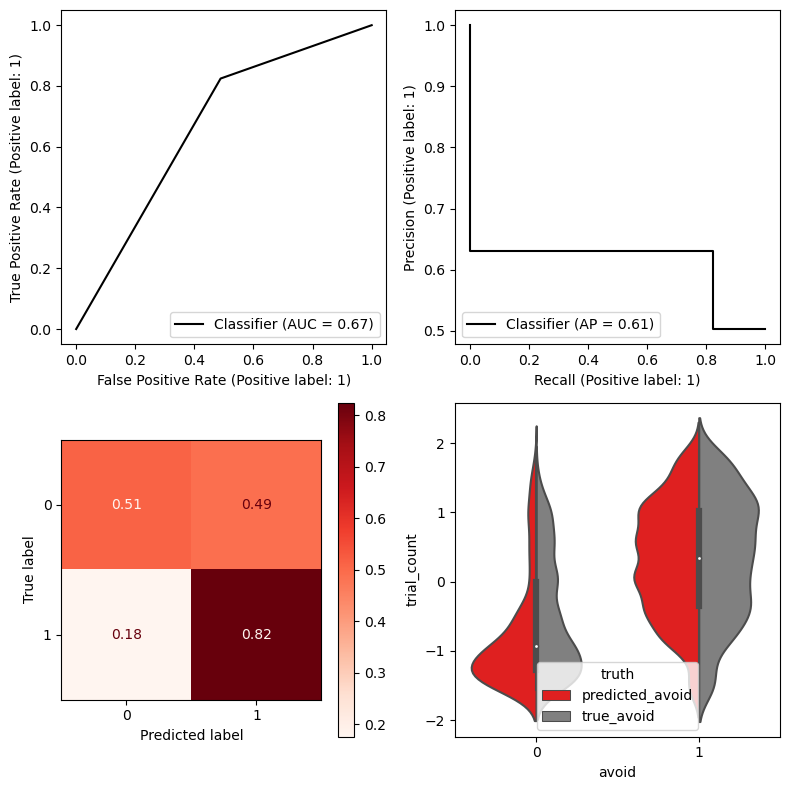

In [143]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
RocCurveDisplay.from_predictions(processor_pipe.y_test,
                                 predicted, 
                                 color = 'k', 
                                 ax = ax[0,0])

PrecisionRecallDisplay.from_predictions(processor_pipe.y_test,
                                        predicted,
                                        color = 'k',
                                        ax = ax[0,1])

ConfusionMatrixDisplay.from_predictions(processor_pipe.y_test,
                                               predicted, 
                                               normalize='true',
                                               cmap = 'Reds',
                                               ax = ax[1,0])

sns.violinplot(data = test_df,
               x = 'avoid', 
               y = 'trial_count', 
               split = True, 
               hue = 'truth',
               alpha = 0.5,
               palette=['red', 'grey'],
               ax = ax[1,1])
# ax[3].legend(loc = 'outer right', bbox_to_anchor = (1, 0.5))
plt.tight_layout()

In [149]:
from xgboost_ray import RayDMatrix, RayParams, train


In [162]:



num_actors = 4
num_cpus_per_actor = 1
ray_params = RayParams(num_actors=num_actors, cpus_per_actor=num_cpus_per_actor)

def train_model(search_space):
    train_set = RayDMatrix(processor_pipe.X_train, processor_pipe.y_train)
    evals_result = {}
    best = train(params=search_space,
                 dtrain = train_set,
                 evals_result=evals_result,
                 evals = [(train_set, 'train')],
                 verbose = False, 
                 ray_params = ray_params)
search_space = {
    "objective": "binary:logistic",
    "n_estimators": range(100, 500, 100),
    "eval_metric": "auc",
    "learning_rate": [0.1, 0.3, 0.5],
    "max_depth": [2, 4, 6]
}
analysis = tune.run(train_model, 
                    config = search_space,
                    metric="auc", 
                    mode = "max", 
                    num_samples = 4, 
                    resources_per_trial=ray_params.get_tune_resources())

2023-09-05 16:12:28,085	INFO tune.py:657 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


In [ ]:
xgb_model = xgb.XGBClassifier(objective ='binary:logistic',
                             n_estimators = 1000, 
                             max_depth =4,
                             learning_rate = .3,
                            #  min_child_weight = 3,
                            metrics = 'roc_auc',
                            )
xgb_model.fit(processor_pipe.X_train, processor_pipe.y_train)